In [145]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
#import genomeview
from pybedtools import BedTool
import mappy as mp
from plotting_utils import figure_path
from matplotlib import rcParams
from peak_utils import *
from tblout_parser import read_tbl

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
peak_path = project_path + '/bed_files/merged_bed/MACS2/annotated'
#peak_path = project_path + '/CLAM//BED_files/peaks/annotation'
peak_tsv = peak_path + '/unfragmented.tsv'
print(peak_tsv)
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype)) \
    .sort_values('pileup', ascending=False)
peak_df.head()

/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.tsv


,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
0,chr1,28975111,28975251,unfragmented.fwd_peak_608,571852,10789.12598,57193.25000,57185.27344,11098.0,15,RNU11,snRNA,+,.,Unannotated,0.0,0.0,Sense
1,chr6,95156834,95156909,unfragmented.rvs_peak_22955,285327,5759.27588,28540.77539,28532.79883,6997.0,15,MTPAP,RBP,-,.,Unannotated,0.0,0.0,Sense
3,chr1,17067008,17067186,unfragmented.fwd_peak_361,131454,2875.36157,13152.87012,13145.43457,3012.0,15,RNU1-4,snRNA,+,RP5-1182A14.7,Long RNA,0.0,0.0,Sense
2,chr15,65597013,65597137,unfragmented.fwd_peak_9458,135673,2774.11182,13574.81543,13567.35254,2817.0,15,RNU5B-1,snRNA,+,.,Unannotated,0.0,0.0,Sense
4,chr12,120729554,120729710,unfragmented.rvs_peak_6635,125923,2581.31641,12599.91992,12592.37305,2619.0,15,U4,snRNA,-,.,Unannotated,0.0,0.0,Sense


In [46]:
ce = color_encoder()
colors = simpsons_palette()
#colors.extend(['black','white'])
random.seed(12)
colors = random.sample(colors, k = len(peak_df.sense_gtype.unique()))
ce.fit(peak_df.sense_gtype, colors)
ce.encoder = {'Long RNA': '#370335',
     'RBP': '#91331F',
     'Repeats': '#197EC0',
     'Unannotated': '#46732E',
     'miRNA': '#FD7446',
     'misc RNA': '#FD8CC1',
     'tRF3':'black',
     'tRF5':'black',
     'piRNA': '#D5E4A2',
     'snRNA': '#8A9197',
     'snoRNA': '#FED439'}

/stor/home/cdw2854/cfNA/plots/peak_utils.py:429: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0, 1e4)


Plotted:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_qc.pdf


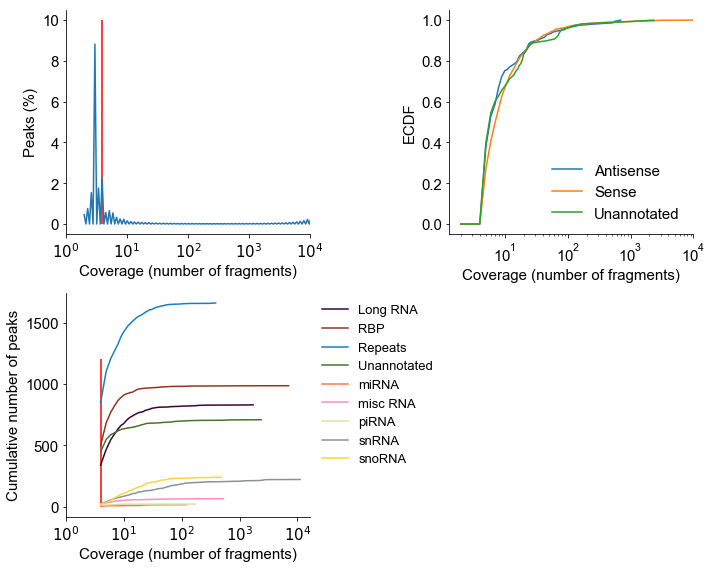

In [48]:
fig = plt.figure(figsize=(10,8))
cov_ax = fig.add_subplot(221)
number_ax = fig.add_subplot(223)
dist_cov_ax = fig.add_subplot(222)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_coverage(peak_df, cov_ax, log=True)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [49]:
peak_df.sense_gtype.unique()

array(['snRNA', 'RBP', 'Unannotated', 'Long RNA', 'misc RNA', 'snoRNA',
       'Repeats', 'piRNA', 'miRNA'], dtype=object)

Saved: /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_figure.pdf


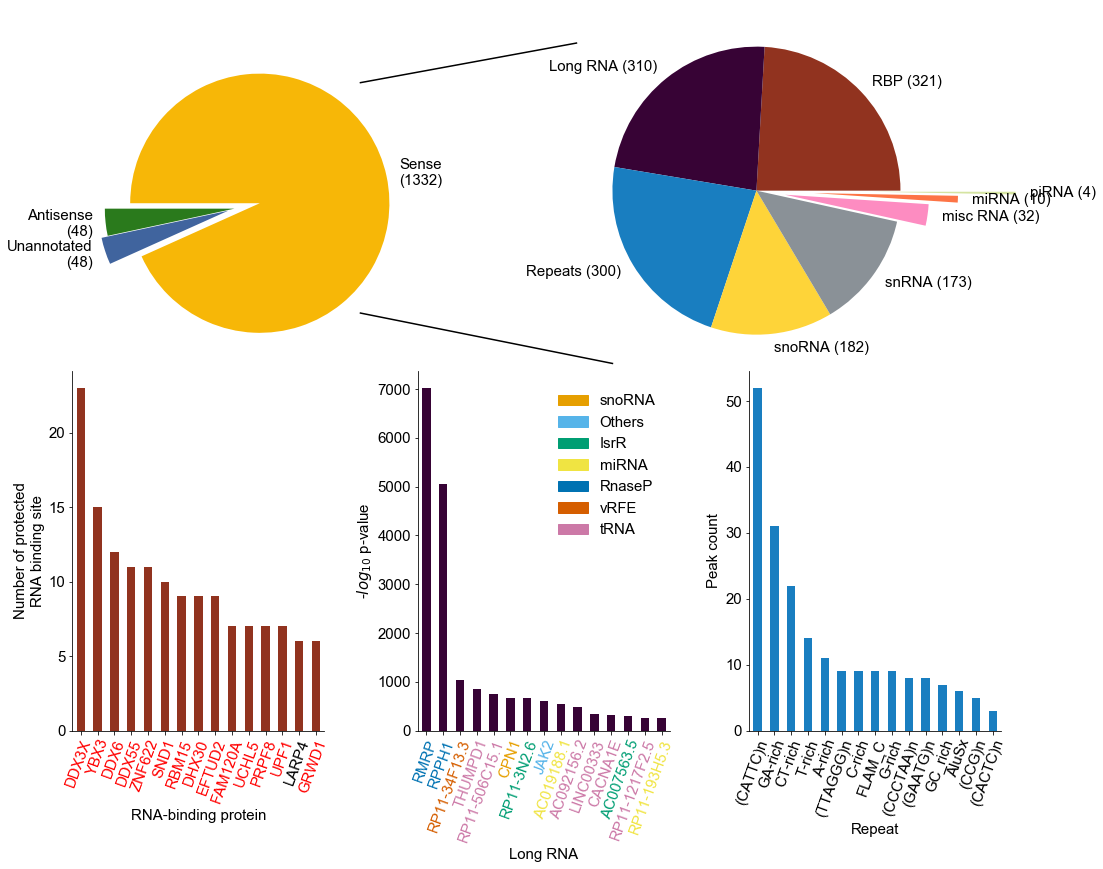

In [146]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.45, 0.45])
pie_ax = fig.add_axes([0.6, 0.5, 0.5, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
plot_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n, y_val = 'log10p')
l1 = mlines.Line2D([0.3,0.6],[0.9,0.955], color= 'black',
                   figure = fig,  transform=fig.transFigure)
l2 = mlines.Line2D([0.3,0.65],[0.58,0.51], color= 'black',
                   figure = fig,  transform=fig.transFigure)
fig.lines.extend([l1, l2])
figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [51]:
import RNA 

lr_peak = peak_df\
    .query('sense_gtype=="Long RNA"') \
    .query('pileup >= %i & sample_count >= %i'%(pileup_cutoff, sample_cutoff))\
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(mt = lambda d: d.seq.map(is_mt))  \
    .assign(shape = lambda d: d.seq.map(RNA.fold))\
    .assign(energy = lambda d: list(map(lambda x: x[1], d['shape'])))\
    .assign(shape = lambda d: list(map(lambda x: x[0], d['shape'])))\
    .assign(width = lambda d: d.end - d.start)\
    .sort_values('log10p', ascending=False)

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width
11,chr9,35657742,35658019,unfragmented.rvs_peak_26714,70202,1631.04382,7027.10205,7020.27002,1711.0,15,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,ACGTGGTTCGTGCTGAAGGCCTGTATCCTAGGCTACACACTGAGGA...,not_MT,....(((.((((((((((.(((((....(((((........(((((...,-103.900002,277
13,chr14,20811226,20811574,unfragmented.rvs_peak_7587,50579,1163.13416,5064.64355,5057.95801,1191.0,15,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TCCCATAGGGCGGAGGGAAGCTCATCAGTGGGGCCACGAGCTGAGT...,not_MT,.......((((((((((((((((....(((....))))))))((((...,-166.100006,348
29,chr15,68132295,68132406,unfragmented.fwd_peak_9504,10347,282.87555,1040.92078,1034.72668,290.0,5,...,RNU6-1,snRNA,0.000000e+00,0.000000e+00,Sense,cgaatttgcgtgtcatccttgcgcaggggccatgctaatcttctct...,not_MT,((((....(((((..(((((..((((.(...(((((((...........,-23.900000,111
35,chr16,20733598,20733724,unfragmented.rvs_peak_9741,8493,230.36537,855.38977,849.31512,234.0,15,...,SFPQ,RBP,0.000000e+00,0.000000e+00,Sense,TAGAACTGCTAACTCATGCCACCATGTTTAATAACATGGCTTTCTC...,not_MT,.......(((((((.(((...(((((((....)))))))..........,-21.799999,126
38,chr9,81357659,81357730,unfragmented.rvs_peak_26895,7419,199.01752,748.02344,741.98596,201.0,15,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AGAGTAAGGTCAGTTAAATAAGCTAACGGGCCCATACCCCGAAAAT...,not_MT,..(((((((..((.......((((((((((......)))..........,-11.300000,71
39,chr10,101817586,101817662,unfragmented.rvs_peak_3546,6722,183.95647,678.27344,672.28210,186.0,15,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AGTTCACTGTAAAGCTAACCCAGCATTAACCTTTTAAGTTAAAGAC...,not_MT,..((((((((((.(((.....)))......((((......)))).....,-17.299999,76
40,chr7,63571927,63571997,unfragmented.rvs_peak_24172,6598,179.31281,665.85236,659.86792,181.0,15,...,RP11-165H4.1,Long RNA,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTAAATAAGCTATCTGGCCCATACCCCAAAAATG...,not_MT,..(((.((((((.((.......)).))))))..))).((((........,-9.500000,70
42,chr9,5095156,5095228,unfragmented.fwd_peak_28467,6018,167.16730,607.92926,601.87054,169.0,15,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAGTAAGTTCAGCTAAATAAGCTATTGGGCCCATTCTCCTGAAAAT...,not_MT,.......(((((...(((..(((....)))..)))...)))))......,-7.000000,72
49,chr4,91759632,91760267,unfragmented.rvs_peak_19978,5343,150.45107,540.27820,534.37061,152.0,15,...,CCSER1,Long RNA,0.000000e+00,0.000000e+00,Sense,CGACAACTCGGTGGTGGCCACTGCGCAGACCAGACTTCGCTCGTAC...,not_MT,........((((((...)))))).(((..(((.....(((.((......,-160.899994,635
54,chr2,140977935,140978004,unfragmented.rvs_peak_14867,4708,133.00676,476.71878,470.85913,134.0,14,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTATAAGCTATCGGGCCCATACCCCAAAAATGTT...,not_MT,.((((.((..((((...))))...(((......))).......(.....,-9.800000,69


In [77]:
cmscan_df = read_tbl(peak_path + '/unfragmented.Long_RNA.tblout') \
    .assign(peakname = lambda d: d['query name'].str.split('(', expand=True).iloc[:,0]\
                                   .str.replace('^RF[0-9]+','')\
                                   .str.strip(' '))\
    .assign(strand = lambda d: np.where(d.strand=="+", 0,1) )\
    .groupby('peakname', as_index=False)\
    .apply(lambda d: d.pipe(lambda d1: d1[d1.strand==d1.strand.min()]).pipe(lambda d1: d1[d1.score==d1.score.max()]))
cmscan_df.head()

E-value    accession  bias description of target    gc    inc mdl  \
0 872  .0   13.5  _23305(+) -  1 0.             4.5 ?   -    no          -   
  874  .0   11.2  _23305(+) -  1 0.             6.9 ?   -    no          -   
1 140        8.1            -   0.0                     -  0.68      ?  cm   
2 83         8.1            -   0.0                     -  0.68      ?  cm   
3 785      1.6 ?            -   0.0                     -  0.42  ?   -  cm   

      mdl from mdl to pass                        query name     score  \
0 872       cm      1    +  RF01618   unfragmented.fwd_peak_  .43   0.   
  874       cm      1    +  RF02278   unfragmented.fwd_peak_  .43   0.   
1 140      203    270    2    unfragmented.fwd_peak_10249(+)       4.8   
2 83       203    270    2    unfragmented.fwd_peak_10270(+)       4.8   
3 785        1     84  1 0   unfragmented.fwd_peak_1102(+) -      17.7   

      seq from seq to  strand            target name trunc  \
0 872       63    106       1                 ceN114    28   
  874       64     91       1  Betaproteobacteria_to    37   
1 140       10     72       0                 snoU89    5'   
2 83        10     72       0                 snoU89    5'   
3 785       15     95       0               SNORD19B    no   

                          peakname  
0 872       unfragmented.fwd_peak_  
  874       unfragmented.fwd_peak_  
1 140  unfragmented.fwd_peak_10249  
2 83   unfragmented.fwd_peak_10270  
3 785   unfragmented.fwd_peak_1102

In [79]:
cmscan_df.reset_index().filter(regex='name')

,query name,target name,peakname
0,RF01618 unfragmented.fwd_peak_,ceN114,unfragmented.fwd_peak_
1,RF02278 unfragmented.fwd_peak_,Betaproteobacteria_to,unfragmented.fwd_peak_
2,unfragmented.fwd_peak_10249(+),snoU89,unfragmented.fwd_peak_10249
3,unfragmented.fwd_peak_10270(+),snoU89,unfragmented.fwd_peak_10270
4,unfragmented.fwd_peak_1102(+) -,SNORD19B,unfragmented.fwd_peak_1102
5,unfragmented.fwd_peak_11480(+),U6,unfragmented.fwd_peak_11480
6,unfragmented.fwd_peak_11520(+),Ms_AS-4,unfragmented.fwd_peak_11520
7,unfragmented.fwd_peak_11606(+),ACAT,unfragmented.fwd_peak_11606
8,unfragmented.fwd_peak_12113(+),suhB,unfragmented.fwd_peak_12113
9,unfragmented.fwd_peak_1215(+) -,PyrD_leader,unfragmented.fwd_peak_1215


In [110]:
lr_peak.merge(cmscan_df, on ='peakname', how='left')\
    .filter(['chrom','start','end', 'peakname','log10p', 'sense_gname','target name','strand_x'])\
    .nlargest(15,'log10p')

,chrom,start,end,peakname,log10p,sense_gname,target name,strand_x
0,chr9,35657742,35658019,unfragmented.rvs_peak_26714,7027.10205,RMRP,RNaseP_nuc,-
1,chr14,20811226,20811574,unfragmented.rvs_peak_7587,5064.64355,RPPH1,RNaseP_nuc,-
2,chr15,68132295,68132406,unfragmented.fwd_peak_9504,1040.92078,RP11-34F13.3,veev_FSE,+
3,chr16,20733598,20733724,unfragmented.rvs_peak_9741,855.38977,THUMPD1,tRNA,-
4,chr9,81357659,81357730,unfragmented.rvs_peak_26895,748.02344,RP11-506C15.1,tRNA,-
5,chr10,101817586,101817662,unfragmented.rvs_peak_3546,678.27344,CPN1,TtnuHACA22,-
6,chr7,63571927,63571997,unfragmented.rvs_peak_24172,665.85236,RP11-3N2.6,IsrR,-
7,chr9,5095156,5095228,unfragmented.fwd_peak_28467,607.92926,JAK2,NaN,+
8,chr4,91759632,91760267,unfragmented.rvs_peak_19978,540.27820,AC019188.1,mir-74,-
9,chr2,140977935,140978004,unfragmented.rvs_peak_14867,476.71878,AC092156.2,tRNA,-


In [70]:
lr_peak.query('width == 1751')

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width
286,chr7,22549930,22551681,unfragmented.rvs_peak_23789,588,23.50228,63.98058,58.83469,23.0,15,...,.,Unannotated,1.045731e-64,1.933405e-62,Sense,CTTTTTCGCAACGGGTTTGCCGCCAGAACACAGGTGTCGTGAAAAC...,not_MT,(((((.((((..((((((((((((........)))((.((....))...,-511.899994,1751


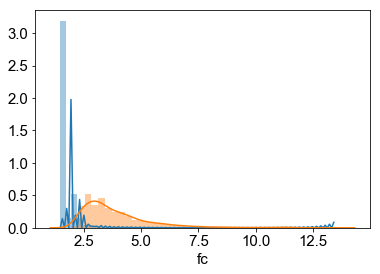

In [67]:
sns.distplot(peak_df.fc.transform(np.log2))
sns.distplot(peak_df.query('pileup >= 4 & sample_count >= 5').fc.transform(np.log2))

In [61]:
lr_peak.query('peakname=="unfragmented.fwd_peak_28467"')

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width
42,chr9,5095156,5095228,unfragmented.fwd_peak_28467,6018,167.1673,607.92926,601.87054,169.0,15,...,.,Unannotated,0.0,0.0,Sense,AAGTAAGTTCAGCTAAATAAGCTATTGGGCCCATTCTCCTGAAAAT...,not_MT,.......(((((...(((..(((....)))..)))...)))))......,-7.0,72


In [60]:
fold = lr_peak.nlargest(20,'log10p').pipe(lambda d: d[~d.sense_gname.str.contains('RMRP|RPPH1|AC019188.1|HIST')])
fold.head()

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width
29,chr15,68132295,68132406,unfragmented.fwd_peak_9504,10347,282.87555,1040.92078,1034.72668,290.0,5,...,RNU6-1,snRNA,0.0,0.0,Sense,cgaatttgcgtgtcatccttgcgcaggggccatgctaatcttctct...,not_MT,((((....(((((..(((((..((((.(...(((((((...........,-23.900000,111
35,chr16,20733598,20733724,unfragmented.rvs_peak_9741,8493,230.36537,855.38977,849.31512,234.0,15,...,SFPQ,RBP,0.0,0.0,Sense,TAGAACTGCTAACTCATGCCACCATGTTTAATAACATGGCTTTCTC...,not_MT,.......(((((((.(((...(((((((....)))))))..........,-21.799999,126
38,chr9,81357659,81357730,unfragmented.rvs_peak_26895,7419,199.01752,748.02344,741.98596,201.0,15,...,.,Unannotated,0.0,0.0,Sense,AGAGTAAGGTCAGTTAAATAAGCTAACGGGCCCATACCCCGAAAAT...,not_MT,..(((((((..((.......((((((((((......)))..........,-11.300000,71
39,chr10,101817586,101817662,unfragmented.rvs_peak_3546,6722,183.95647,678.27344,672.28210,186.0,15,...,.,Unannotated,0.0,0.0,Sense,AGTTCACTGTAAAGCTAACCCAGCATTAACCTTTTAAGTTAAAGAC...,not_MT,..((((((((((.(((.....)))......((((......)))).....,-17.299999,76
40,chr7,63571927,63571997,unfragmented.rvs_peak_24172,6598,179.31281,665.85236,659.86792,181.0,15,...,RP11-165H4.1,Long RNA,0.0,0.0,Sense,AAGTAAGGTCAGCTAAATAAGCTATCTGGCCCATACCCCAAAAATG...,not_MT,..(((.((((((.((.......)).))))))..))).((((........,-9.500000,70


In [42]:
import random
from collections import Counter
from scipy.stats import ranksums

es = []
bases = list('ACTG')
for w, seq in zip(fold.width, fold.seq):
    b = Counter(seq.upper())
    weights = [b[n] for n in bases]
    for i in range(20):
        random_seq = ''.join(random.choices(list('ACTG'), 
                                            k=w, weights=weights))
        s, e = RNA.fold(random_seq)
        es.append(e)

In [43]:
w, p = ranksums(es, fold.energy.values)

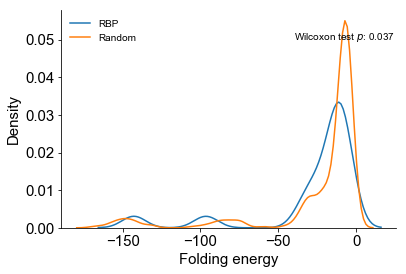

In [44]:
ax = plt.subplot()
sns.distplot(fold.energy, label = 'RBP', ax = ax, hist=False)
sns.distplot(es, label = 'Random', ax = ax, hist=False)
ax.text(-40,0.05, 'Wilcoxon test $p$: %.3f' %p)
ax.legend(frameon=False)
sns.despine()
ax.set_xlabel('Folding energy')
ax.set_ylabel('Density')
plt.savefig(figure_path + '/fold_energy.pdf', bbox_inches='tight')

In [15]:
colnames = rbp.columns.tolist()
colnames.extend(['tRNA_chrom','tRNA_start','tRNA_end','tRNA_name', 
                'tRNA_score','tRNA_strand', 'tRNA_type',
               'tRNA_id','distance'])

closest = BedTool().from_dataframe(rbp.sort_values(['chrom','start','end']))\
    .closest(b = '/stor/work/Lambowitz/ref/hg19/new_genes/tRNA.sorted.bed', d= True) \
    .to_dataframe(names = colnames) 

In [16]:
'|'.join(closest.nlargest(20, 'log10p').query('distance < 100').sense_gname)

'AC092156.2|RP11-3N2.6|JAK2|RP11-91A15.2|RP11-165H4.1'

In [17]:
RNA.fold(rbp.seq.values[2])

['.((((.((..((((...))))...(((......))).......(..((......))..))).))))...',
 -9.800000190734863]

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


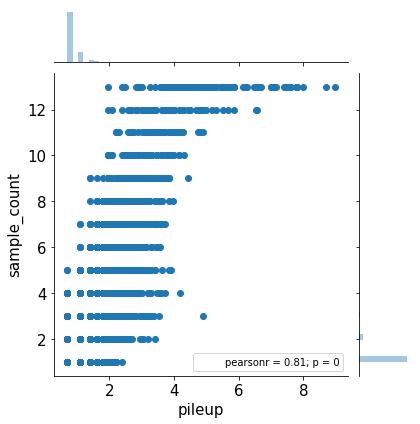

In [18]:
sns.jointplot(peak_df.pileup.transform(np.log),
            peak_df.sample_count)

In [9]:
','.join(rbp_df.head(15).index)

'UCHL5,LARP4,DHX30,EFTUD2,YBX3,XPO5,DDX6,METAP2,SND1,SRSF7,MTPAP,PCBP2,SUB1,EIF3D,TIA1'

In [10]:
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


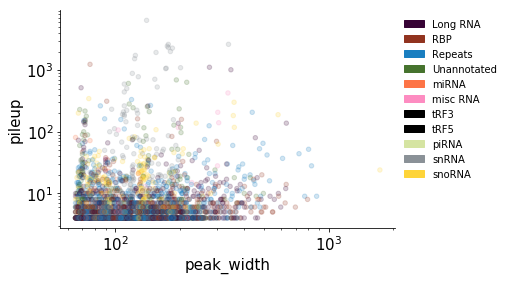

In [11]:
ax = plt.subplot()
pdf = peak_df\
    .pipe(lambda d: d[~d.sense_gtype.str.contains('tRF')])\
    .query('pileup >= %i' %pileup_cutoff)\
    .assign(peak_width = lambda d: d.end-d.start)\
    .assign(log_pile = lambda d: d.pileup.transform(np.log10))

pdf.plot.scatter('peak_width','pileup', 
                  color = ce.transform(pdf.sense_gtype), ax = ax,
                 alpha = 0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ce.show_legend(ax = ax, bbox_to_anchor =(1,1), frameon=False)
sns.despine()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


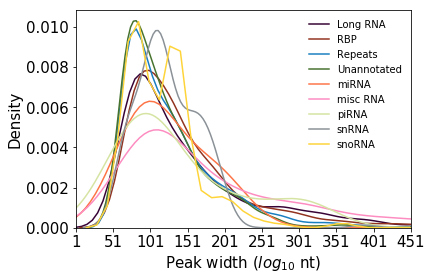

In [19]:
ax = plt.subplot()

for gt, gd in peak_df\
            .query('pileup >= %i' %(pileup_cutoff))\
            .assign(peak_width = lambda d: (d.end-d.start))\
            .groupby('sense_gtype'):
    alpha = 1 if gt in ["Long RNA"] else 1
    sns.distplot(gd.peak_width, ax = ax, kde_kws={'alpha':alpha},
                label = gt, color = ce.encoder[gt],
                hist=False)
lgd = ax.legend(frameon=False)
for lh in lgd.legendHandles: 
    lh.set_alpha(1)
ax.set_ylabel('Density')
ax.set_xlabel('Peak width ($log_{10}$ nt)')

x_range = np.arange(1,500, 50)
ax.set_xlim(x_range.min(), x_range.max())
ax.set_xticks(x_range)
for xt, x in zip(ax.get_xticklabels(), x_range):
    xt.set_text(r'$10^{%s}$' %(x))

In [ ]:
lR_peak = peak_df[peak_df.sense_gtype.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

In [ ]:
anti_peaks.antisense_gtype.unique()

In [ ]:
anti_peaks = peak_df.query('is_sense == "Antisense"')\
    .pipe(lambda d: d[~d.antisense_gtype.str.contains('tRF')])

NameError: name 'anti_peaks' is not defined

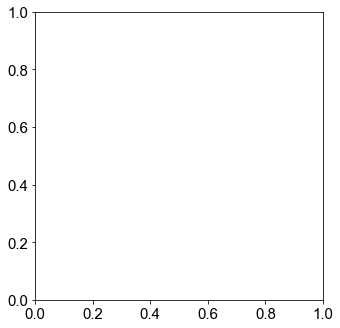

In [55]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0.1,0.4,0.8])
plot_peak_pie(anti_peaks, ax, ce, gtype='antisense_gtype')
ax = fig.add_axes([0.7, 0, 0.4, 1])
anti_plot = anti_peaks.nlargest(15, 'log10p')
anti_plot.plot\
    .bar('antisense_gname', 'log10p', 
         color = ce.transform(anti_plot\
                               .antisense_gtype),
        ax = ax)
ax.legend().set_visible(False)
ax.set_xlabel('RNA type')
ax.set_ylabel('-$log_{10}$ p-value')
sns.despine()
fig.tight_layout()
figurename = figure_path + '/peak_anti.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [147]:
fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
fa.fetch('chr12',22158771,22158870)

'aacaaccaaatttaaaaatgggcaggctgggcatgtagctcatgcttgtaatcccagcacattaggaggccaaggcaggcgggtccatttgagctcagg'

In [148]:
columns = peak_df.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand'])
intron_df = BedTool()\
    .from_dataframe(peak_df )\
    .intersect('/stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed', 
               f= 0.8,F=0.8,wb=True)\
    .to_dataframe(names = columns)
intron_df.shape

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-



(117, 24)

In [149]:
intron_df \
    .query('pileup >= 5' )

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gtype,pvalue,FDR,is_sense,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand
0,chr19,11333582,11333668,unfragmented.rvs_peak_12700,14180,378.47632,1424.24146,1418.05725,390.0,15,...,Unannotated,0.000000e+00,0.000000e+00,Sense,chr19,11333582,11333668,ENSG00000130158.9,0,-
1,chr22,50356514,50356587,unfragmented.fwd_peak_18809,3888,119.56595,394.73831,388.87396,122.0,14,...,Unannotated,0.000000e+00,0.000000e+00,Sense,chr22,50356514,50356587,ENSG00000198355.4,0,+
2,chr17,39913789,39913885,unfragmented.rvs_peak_11075,1294,45.86183,134.86975,129.44292,46.0,15,...,Unannotated,1.349740e-135,4.632400e-133,Sense,chr17,39913789,39913885,ENSG00000173801.12,0,-
3,chr16,16425621,16425710,unfragmented.fwd_peak_10268,1016,37.94965,107.07838,101.69933,38.0,11,...,Unannotated,8.348722e-108,2.408546e-105,Sense,chr16,16425621,16425710,ENSG00000183889.8,0,+
4,chr16,2149772,2149861,unfragmented.rvs_peak_9500,974,36.90580,102.79501,97.45876,37.0,11,...,Unannotated,1.603208e-103,4.432426e-101,Sense,chr16,2149772,2149861,ENSG00000008710.13,0,-
5,chr16,18430618,18430707,unfragmented.rvs_peak_9712,783,31.03070,83.60403,78.34608,31.0,14,...,Unannotated,2.488685e-84,5.851154e-82,Sense,chr16,18430618,18430707,ENSG00000214940.4,0,-
6,chr15,91423005,91423096,unfragmented.fwd_peak_9851,772,30.18170,82.49812,77.23586,30.0,12,...,Unannotated,3.175996e-83,7.379928e-81,Sense,chr15,91423005,91423096,ENSG00000140564.6,0,+
7,chr16,18470720,18470809,unfragmented.rvs_peak_9715,656,26.31727,70.86958,65.67661,26.0,12,...,Unannotated,1.350268e-71,2.724166e-69,Sense,chr16,18470720,18470809,ENSG00000233024.3,0,-
8,chr16,15027134,15027223,unfragmented.fwd_peak_10249,577,24.24674,62.89630,57.74174,24.0,12,...,Unannotated,1.269697e-63,2.311700e-61,Sense,chr16,15027134,15027223,ENSG00000183426.11,0,+
9,chr17,73500562,73500652,unfragmented.rvs_peak_11507,567,23.39313,61.86729,56.73454,23.0,12,...,Unannotated,1.357407e-62,2.384165e-60,Sense,chr17,73500562,73500652,ENSG00000177303.5,0,-


In [150]:
ss_dinucleotide = defaultdict(int)
ss_dinucleotide_seq = defaultdict(list)
seqs = []
fa = pysam.Fastafile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
def fetch_seq(chrom, start, end, strand):
    intron_seq = fa.fetch(chrom, start - 1, end)
    intron_seq = intron_seq if strand == "+" else reverse_complement(intron_seq)
    return intron_seq
    
    

intron_df = intron_df.query('pileup >=3') \
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(dinucleotide = lambda d: d.seq.str.slice(0,2) + ':' + (d.seq + 'N').str.slice(-3,-1))
intron_df.head()

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,FDR,is_sense,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand,seq,dinucleotide
0,chr19,11333582,11333668,unfragmented.rvs_peak_12700,14180,378.47632,1424.24146,1418.05725,390.0,15,...,0.000000e+00,Sense,chr19,11333582,11333668,ENSG00000130158.9,0,-,ccacaagaacagtaggagggaaactgccccagggatttgattatct...,cc:gg
1,chr22,50356514,50356587,unfragmented.fwd_peak_18809,3888,119.56595,394.73831,388.87396,122.0,14,...,0.000000e+00,Sense,chr22,50356514,50356587,ENSG00000198355.4,0,+,CACTGACAATTGTAGGCAAGGGACAGGACAAGTTGACATCAGGGTG...,CA:CA
2,chr17,39913789,39913885,unfragmented.rvs_peak_11075,1294,45.86183,134.86975,129.44292,46.0,15,...,4.632400e-133,Sense,chr17,39913789,39913885,ENSG00000173801.12,0,-,GTAATAGTAAATTGGATTCTCTCTTGATTCATTTTTTATAACACAA...,GT:ga
3,chr16,16425621,16425710,unfragmented.fwd_peak_10268,1016,37.94965,107.07838,101.69933,38.0,11,...,2.408546e-105,Sense,chr16,16425621,16425710,ENSG00000183889.8,0,+,ATATTCAGTATAACACTGATACCCTTTACTCTCAAATATTTGACCC...,AT:TT
4,chr16,2149772,2149861,unfragmented.rvs_peak_9500,974,36.90580,102.79501,97.45876,37.0,11,...,4.432426e-101,Sense,chr16,2149772,2149861,ENSG00000008710.13,0,-,CACATTGTTAAAATTATACATGTTATATGCTGAAAGGAGAAGCAAG...,CA:tt


In [151]:
tablename = figure_path + '/intron_table.csv'
intron_df \
    .filter(regex='chrom|start|end|log10|pileup|intron_gene|seq') \
    .sort_values('pileup', ascending=False)\
    .to_csv(tablename, index=False)
print('Written: ', tablename)

Written:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/intron_table.csv


In [ ]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

,start,end,score,fc,log10p,log10q,pileup,sample_count,pvalue,FDR,intron_start,intron_end,intron_score,length
count,5.800000e+01,5.800000e+01,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,5.800000e+01,5.800000e+01,5.800000e+01,5.800000e+01,58.0,58.000000
mean,4.767478e+07,4.767488e+07,539.741379,19.756247,58.647350,54.023962,19.379310,5.965517,2.432693e-10,2.335852e-09,4.767478e+07,4.767488e+07,0.0,100.396552
std,4.560617e+07,4.560618e+07,1904.694068,50.894030,190.765142,190.471551,52.554676,3.815782,9.167530e-10,7.249685e-09,4.560617e+07,4.560618e+07,0.0,23.834178
min,7.817520e+05,7.818930e+05,44.000000,4.728390,8.303810,4.413130,4.000000,1.000000,0.000000e+00,0.000000e+00,7.817510e+05,7.819270e+05,0.0,68.000000
25%,1.395742e+07,1.395750e+07,61.000000,5.092370,10.338038,6.151808,4.250000,3.000000,2.366410e-35,2.371095e-33,1.395742e+07,1.395751e+07,0.0,85.250000
50%,4.133290e+07,4.133301e+07,106.500000,6.842310,15.173120,10.674495,6.000000,4.500000,6.736796e-16,2.627181e-14,4.133290e+07,4.133301e+07,0.0,90.000000
75%,6.303656e+07,6.303664e+07,297.000000,15.944780,34.625910,29.737300,16.000000,8.000000,5.047878e-11,8.577937e-10,6.303656e+07,6.303664e+07,0.0,120.000000
max,1.840983e+08,1.840984e+08,14180.000000,378.476320,1424.241460,1418.057250,390.000000,15.000000,4.968096e-09,3.830662e-08,1.840983e+08,1.840984e+08,0.0,182.000000


In [ ]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
glist

In [ ]:
%tb
rnk = glist\
    .filter(['symbol','pileup']) \
    .pipe(lambda d: d[~d.symbol.str.contains('^AC')])\
    .rename(columns={'symbol':'gene_name'})
#res = gsp.prerank(rnk = rnk, gene_sets='/stor/work/Lambowitz/ref/gene_sets/c2.all.v6.2.symbols.gmt')
print('\n'.join(rnk.gene_name.tolist()))



In [ ]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

In [ ]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

In [ ]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

In [ ]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

In [ ]:
import gseapy as gsp

In [ ]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

In [ ]:
res.res2d

In [ ]:
aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
aln = aligner.map(fa.fetch('chr17',33981908,33982067))

In [ ]:
print(next(aln))

In [ ]:
def check_MT(peaks, return_column=False):
    mt = 0
    aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
    fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
    mts = []
    for peak_count, row in peaks.reset_index().iterrows():
        seq = fa.fetch(row['chrom'], row['start'], row['end'])
        seq = seq if row['strand'] == "+" else reverse_complement(seq)
    
        alns = aligner.map(seq)
        try:
            aln = next(alns)
            mt += 1
            mts.append('MT')
            #print(aln.cigar_str)
        except StopIteration:
            #print(row)
            mts.append('no')
            pass


    print('%i seq: %i in MT' %(peak_count, mt))
    if return_column:
        return mts

In [ ]:
anti = peak_df.query('pileup >= 5').query('is_sense == "Unannotated"')
anti['MT'] = check_MT(anti, return_column=True)

In [ ]:
peak_df.query("sense_gtype == 'tRF3'")